In [2]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 7.7 MB/s eta 0:00:00


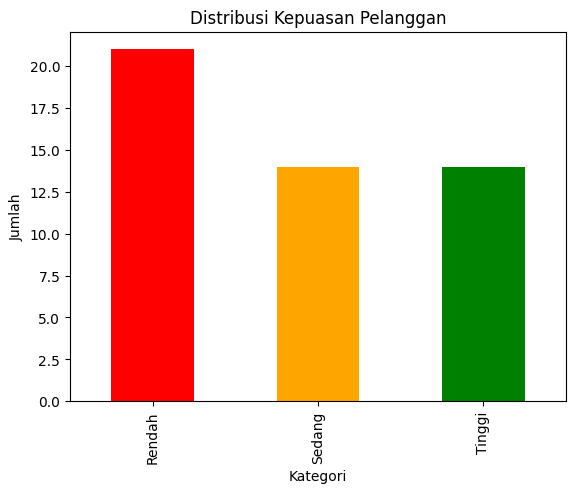

   waktu_tunggu  kualitas_layanan  prediksi_kepuasan kategori_kepuasan
0             5                 9           8.600000            Tinggi
1            10                 7           8.238095            Tinggi
2            15                 6           5.000000            Sedang
3            20                 5           5.000000            Sedang
4             3                 8           8.444444            Tinggi


In [4]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# =======================
# 1. Load Dataset
# =======================
df = pd.read_csv("dataset_kepuasan.csv")

# =======================
# 2. Definisi Variabel Fuzzy
# =======================
waktu_tunggu = ctrl.Antecedent(np.arange(0, 61, 1), 'waktu_tunggu')
kualitas_layanan = ctrl.Antecedent(np.arange(0, 11, 1), 'kualitas_layanan')
kepuasan = ctrl.Consequent(np.arange(0, 11, 1), 'kepuasan')

# Membership function waktu tunggu
waktu_tunggu['cepat']  = fuzz.trimf(waktu_tunggu.universe, [0, 0, 15])
waktu_tunggu['sedang'] = fuzz.trimf(waktu_tunggu.universe, [10, 25, 40])
waktu_tunggu['lama']   = fuzz.trimf(waktu_tunggu.universe, [30, 60, 60])

# Membership function kualitas layanan
kualitas_layanan['buruk']  = fuzz.trimf(kualitas_layanan.universe, [0, 0, 5])
kualitas_layanan['sedang'] = fuzz.trimf(kualitas_layanan.universe, [3, 5, 7])
kualitas_layanan['baik']   = fuzz.trimf(kualitas_layanan.universe, [6, 10, 10])

# Membership function kepuasan (output)
kepuasan['rendah'] = fuzz.trimf(kepuasan.universe, [0, 0, 5])
kepuasan['sedang'] = fuzz.trimf(kepuasan.universe, [3, 5, 7])
kepuasan['tinggi'] = fuzz.trimf(kepuasan.universe, [6, 10, 10])

# =======================
# 3. Aturan Fuzzy
# =======================
rule1 = ctrl.Rule(waktu_tunggu['cepat'] & kualitas_layanan['baik'], kepuasan['tinggi'])
rule2 = ctrl.Rule(waktu_tunggu['lama'] & kualitas_layanan['buruk'], kepuasan['rendah'])
rule3 = ctrl.Rule(waktu_tunggu['sedang'] & kualitas_layanan['sedang'], kepuasan['sedang'])
rule4 = ctrl.Rule(kualitas_layanan['baik'], kepuasan['tinggi'])
rule5 = ctrl.Rule(waktu_tunggu['lama'], kepuasan['rendah'])
# tambahan biar semua kombinasi ada
rule6 = ctrl.Rule(waktu_tunggu['sedang'] & kualitas_layanan['buruk'], kepuasan['rendah'])
rule7 = ctrl.Rule(waktu_tunggu['lama'] & kualitas_layanan['baik'], kepuasan['sedang'])
rule8 = ctrl.Rule(waktu_tunggu['cepat'] & kualitas_layanan['buruk'], kepuasan['sedang'])

# =======================
# 4. Sistem Kontrol
# =======================
kepuasan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
kepuasan_sim = ctrl.ControlSystemSimulation(kepuasan_ctrl)

# =======================
# 5. Proses Dataset
# =======================
hasil = []
for i, row in df.iterrows():
    try:
        kepuasan_sim.input['waktu_tunggu'] = row['waktu_tunggu']
        kepuasan_sim.input['kualitas_layanan'] = row['kualitas_layanan']
        kepuasan_sim.compute()
        hasil.append(kepuasan_sim.output['kepuasan'])
    except:
        hasil.append(np.nan)  # kalau ada error, isi NaN

df['prediksi_kepuasan'] = hasil

# Insight: klasifikasi kategori
df['kategori_kepuasan'] = pd.cut(df['prediksi_kepuasan'],
                                 bins=[0,4,7,10],
                                 labels=['Rendah','Sedang','Tinggi'])

# =======================
# 6. Plot Distribusi
# =======================
df['kategori_kepuasan'].value_counts().plot(kind='bar', color=['red','orange','green'])
plt.title("Distribusi Kepuasan Pelanggan")
plt.xlabel("Kategori")
plt.ylabel("Jumlah")
plt.show()

# =======================
# 7. Simpan Hasil
# =======================
df.to_csv("hasil_kepuasan.csv", index=False)
print(df.head())
